# 1. Intro

For an intro and more context about this project click <a href="https://github.com/4rn3/rl_school_project#readme">here<a/>

# 2. Algorithms & setup

In [77]:
import os, time, random
from collections import deque
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np

import gym
from gym.spaces import Box
from gym.wrappers import FrameStack, GrayScaleObservation, ResizeObservation, Monitor

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, Input, MaxPooling2D
from keras.optimizers import Adam
from tensorflow.keras.models import load_model

random.seed(1337)
RANDOM_SEED = 1337
tf.random.set_seed(RANDOM_SEED)
tf.compat.v1.GPUOptions(allow_growth=True)

print(gym.__version__)
print(tf.__version__) #2.10 last version to support GPU on win
print(tf.config.list_physical_devices('GPU'))

0.19.0
2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
env = gym.make("SpaceInvaders-v4")
env = GrayScaleObservation(env,keep_dim=True)
env = ResizeObservation(env, (84,84)) #resize
env = FrameStack(env, 4) #gain extra info by combining multiple frames i.e is mario landing or jumping

In [3]:
print("Observation space: ", env.observation_space.shape)
print("# Actions: ", env.action_space.n)
print("Available actions: ", env.get_action_meanings())

Observation space:  (4, 84, 84, 1)
# Actions:  6
Available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


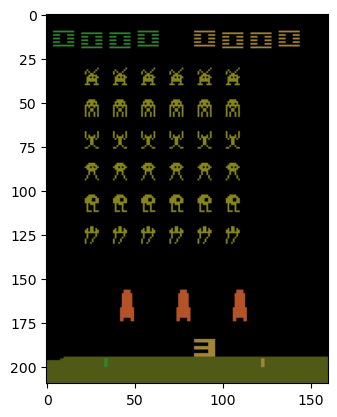

In [4]:
env_screen = env.render(mode = 'rgb_array')
plt.imshow(env_screen)

In [11]:
def plot_res(values, title=''):   
    ''' Plot the reward curve and histogram of results over time.'''
   
    # Define the figure
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    f.suptitle(title)
    ax[0].plot(values, label='score per run')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    x = range(len(values))
    ax[0].legend()
    # Calculate the trend
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"--", label='trend')
    except:
        print('')
    
    # Plot the histogram of results
    ax[1].hist(values[-50:])
    ax[1].set_xlabel('Scores per Last 50 Episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    plt.savefig(f"./plots/{title}.jpg")
    plt.show()

# 2.1 DQN

In [80]:
#hyp
TRAIN_EPISODE = 100
TEST_EPISODE = 10
LR = 1e-3
MEM_LEN = 50000
BATCH_SIZE = 500
UPDATE_TARGET_TRESHOLD = 5
AGGREGATE_STATS = 5
MODEL_NAME = "DQN"
MIN_REPLAY_SIZE = 1000

#Bellman hyp
EPSILON = 1
MAX_EPSILON = 1
MIN_EPSILON = 0.01
DECAY = 0.03
BEL_LR = 0.7
DISCOUNT = 0.66

In [81]:
def agent(state_shape, action_shape):
    model = Sequential()
    #Feature generation
    model.add(Conv2D(32, (2, 2), strides=(4), input_shape=state_shape, activation="relu"))
    model.add(Conv2D(64, (1, 1), activation="relu"))
    model.add(Conv2D(64, (1, 1), activation="relu"))
    #Dim reduction
    model.add(Flatten())
    #FC classifier
    model.add(Dense(512, activation="relu"))
    model.add(Dense(action_shape, activation="linear"))
    
    model.compile(loss="mse", optimizer=Adam(learning_rate=LR), metrics=['accuracy'])    
    return model

In [82]:
model = agent(env.observation_space.shape, env.action_space.n) #init prediction model
target_model = agent(env.observation_space.shape, env.action_space.n) #init target model
target_model.set_weights(model.get_weights())

replay_memory = deque(maxlen=MEM_LEN) #init memory

ResourceExhaustedError: {{function_node __wrapped__StatelessRandomUniformV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[112896,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:StatelessRandomUniformV2]

In [ ]:
def batch_train(env, replay_memory, model, target_model, done):
    learning_rate = BEL_LR
    discount_factor = DISCOUNT
    
    if len(replay_memory) < MIN_REPLAY_SIZE:
        return
    batch_size = BATCH_SIZE
    mini_batch = random.sample(replay_memory, batch_size)
    
    #Predicting the Q-values
    current_states = np.array([transition[0] for transition in mini_batch]) #add current_state from minibatch
    current_qs_list = model.predict(current_states, verbose=0)

    new_current_states = np.array([transition[3]for transition in mini_batch]) #add new_current_state from minibatch
    future_qs_list = target_model.predict(new_current_states, verbose=0)
  
    X, y = [], []

   #Updating Q-values
    for index, (observation, action, reward, new_observation, done) in enumerate(mini_batch):
        if not done:
            max_future_q = reward + discount_factor * np.max(future_qs_list[index])
        else:
            max_future_q = reward
            
        #Bellman
        current_qs = current_qs_list[index]
        current_qs[action] = (1 - learning_rate) * current_qs[action] + learning_rate * max_future_q
        
        X.append(observation)
        y.append(current_qs)
    
    model.fit(np.array(X), np.array(y), batch_size=batch_size, verbose=0, shuffle=False)

In [ ]:
#Train loop
X, y, Total_rewards, time_tracking = [], [], [], []

steps_to_update_target_model = 0

total_start = time.time()

for episode in trange(TRAIN_EPISODE):
    n_steps_episode = 0
    total_training_rewards = 0
    ep_rewards = []

    observation = env.reset()
    done = False
    
    while not done:
        #track time
        start = time.time()
        
        steps_to_update_target_model += 1
        random_number = np.random.rand()
        #Exploration
        if random_number <= EPSILON:
            action = env.action_space.sample()
        #Exploitation    
        else:
            predicted = model.predict(np.array(observation), verbose=0).flatten()
            action = np.argmax(predicted)

        new_observation, reward, done, info = env.step(action)
        total_training_rewards += reward
        ep_rewards.append(reward)
        
        replay_memory.append([observation, action, reward, new_observation, done])

        #Update prediction model
        if steps_to_update_target_model % 4 == 0 or done:
            batch_train(env, replay_memory, model, target_model, done)
        
        observation = new_observation
        
        n_steps_episode += 1
        
        if done:
            stop = time.time()
            time_tracking.append(stop-start)
            
            print('{} Total training rewards: {} after n steps = {}'.format(episode, total_training_rewards, n_steps_episode))
            Total_rewards.append(total_training_rewards)

            #Update target model
            if steps_to_update_target_model >= UPDATE_TARGET_TRESHOLD:
                target_model.set_weights(model.get_weights())
                steps_to_update_target_model = 0
            break
    
    #Update epsilon 
    EPSILON = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * np.exp(-DECAY * episode)
    
    avg_total_rewards = round(np.mean(Total_rewards[-100:]),2)
    
    #Save model and metrics
    if episode % AGGREGATE_STATS == 0:
        avg_ep_reward = round(sum(ep_rewards)/len(ep_rewards),2)
        min_ep_reward = min(ep_rewards)
        max_ep_reward = max(ep_rewards)
        avg_time = round(sum(time_tracking)/len(time_tracking),2) #not time per episod
        
        model.save(f'./models/DQN_models/{avg_total_rewards}_{str(episode)}_{MODEL_NAME}.h5')
        
        with open(f"./logs/DQN_logs/DQN.txt","a") as f:
            f.write(f"{avg_ep_reward},{min_ep_reward},{max_ep_reward},{avg_total_rewards},{avg_time},{round(EPSILON,2)},{str(episode)}\n")
        
        time_tracking = []
env.close()
total_stop = time.time()
total_time = total_stop-total_start

In [15]:
total_time = "2:51:36" #100episodes

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


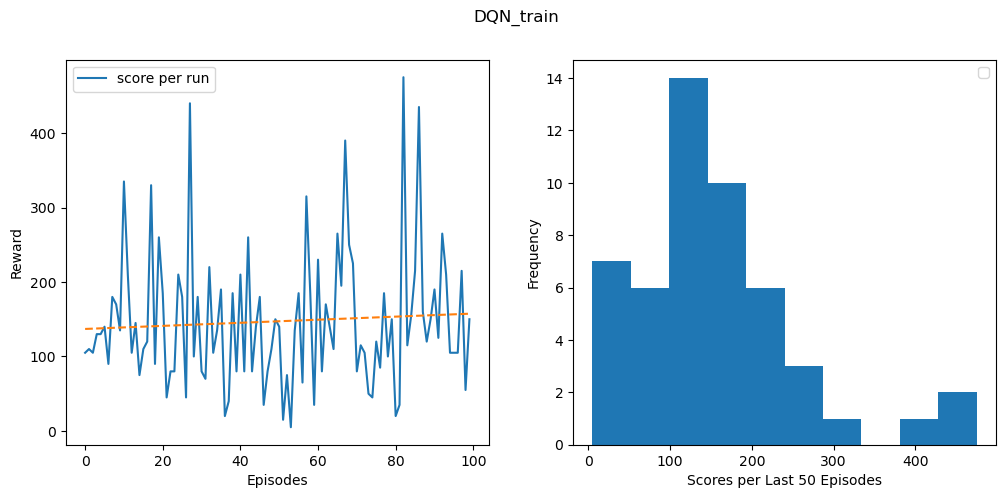

In [29]:
#Plot trainig
plot_res(Total_rewards,'DQN_train')

In [5]:
### Load the best model
best_model = sorted(os.listdir("./models/DQN_models"))[-1]
print("Loaded: ", best_model)
model = load_model(os.path.join("./models/DQN_models",best_model), compile=False)

Loaded:  0.25_60_DQN.h5


In [13]:
#Evaluate model
Total_reward = []
for episode in trange(TEST_EPISODE):
        n_steps_episode = 0
        total_training_rewards = 0
        observation = env.reset()
        done = False
        while not done:
            
            observation = tf.convert_to_tensor(observation)
            observation = tf.expand_dims(observation, 0)
            
            predicted = model.predict(observation, verbose=0)
            action = np.argmax(predicted)
            new_observation, reward, done, info = env.step(action)
            total_training_rewards += reward  
            observation = new_observation
            
            n_steps_episode += 1
        print('{} Reward = {}'.format(episode,total_training_rewards))
        Total_reward.append(total_training_rewards)
env.close()

  0%|          | 0/10 [00:00<?, ?it/s]

0 Reward = 110.0
1 Reward = 335.0
2 Reward = 395.0
3 Reward = 60.0
4 Reward = 55.0
5 Reward = 535.0
6 Reward = 370.0
7 Reward = 185.0
8 Reward = 220.0
9 Reward = 30.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


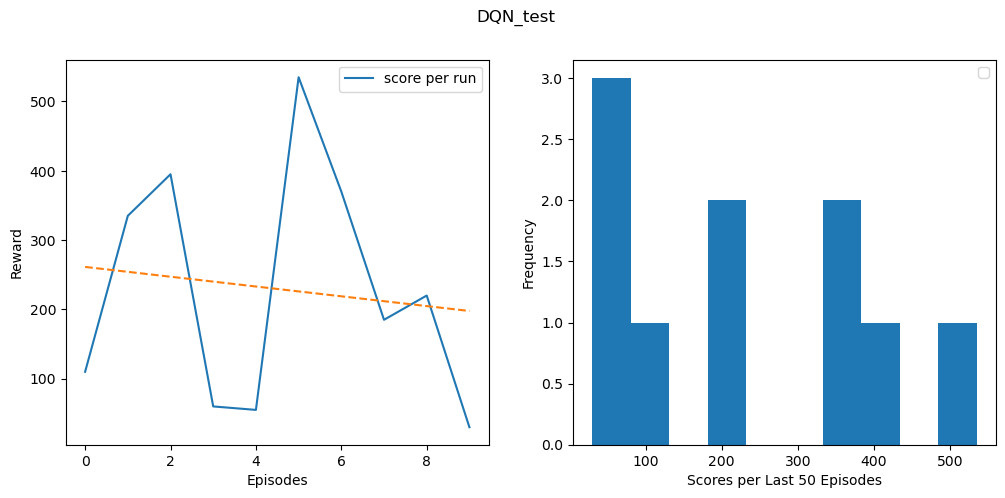

In [14]:
plot_res(Total_reward,'DQN_test')

### 2.1.2 Compare model to random actions

In [37]:
#play 1 game of the best model
epochs, rewards = 0, 0
observation = env.reset()
done = False

while not done:
    
    observation = tf.convert_to_tensor(observation)
    observation = tf.expand_dims(observation, 0)
    
    predicted = model.predict(np.array(observation), verbose=0).flatten()
    action = np.argmax(predicted)
    observation, reward, done, info = env.step(action)
    env.render()
    rewards  += reward
    epochs += 1
    
env.close()
print(f"Reward: {rewards}") 

Reward: 190.0


# 2.2 Actor-Critic

In [67]:
#hyp
TRAIN_EPISODE = 100
TEST_EPISODE = 10
LR = 1e-2
GOAL = 250
AGGREGATE_STATS = 5
MAX_STEPS_PER_EPISODEE = 10000
MODEL_NAME = "AC"
GAMMA = 0.99 
EPS = np.finfo(np.float32).eps.item() #smallest number such that 1.0 + eps != 1.0

In [68]:
# Define the different layers
inputs = Input(shape=env.observation_space.shape[1:])

common = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
common = MaxPooling2D(pool_size=(2, 2))(common)

common = Conv2D(32, kernel_size=(3, 3), activation='relu')(common)
common = MaxPooling2D(pool_size=(2, 2))(common)

common = Conv2D(32, kernel_size=(3, 3), activation='relu')(common)
common = MaxPooling2D(pool_size=(2, 2))(common)

common = Flatten()(common)

actor = Dense(env.action_space.n, activation="softmax")(common)
critic = Dense(1)(common)

# Construct the model
model = keras.Model(inputs=inputs, outputs=[actor, critic])
print(model.summary())

# Add adam optimizer and Huber loss
optimizer = keras.optimizers.Adam(learning_rate=LR)
huber_loss = keras.losses.Huber()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 84, 84, 1)]  0           []                               
                                                                                                  
 conv2d_34 (Conv2D)             (None, 82, 82, 32)   320         ['input_20[0][0]']               
                                                                                                  
 max_pooling2d_32 (MaxPooling2D  (None, 41, 41, 32)  0           ['conv2d_34[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_35 (Conv2D)             (None, 39, 39, 32)   9248        ['max_pooling2d_32[0][0]'] 

In [69]:
action_probs_history = []
critic_value_history = []
rewards_history = []
score_history = []

average_reward = 0
episode_count = 0

total_start = time.time()
while True:
    state = env.reset()
    episode_reward = 0
    with tf.GradientTape() as tape:
        for timestep in range(1, MAX_STEPS_PER_EPISODEE):

            state = tf.convert_to_tensor(state)
            
            action_probs, critic_value = model(state)
            
            p = np.squeeze(action_probs)
            
            action = np.random.choice(env.action_space.n, p=p[0])
            action_probs_history.append(tf.math.log(action_probs[0, action]))
            
            critic_value_history.append(critic_value[0, 0])

            state, reward, done, info = env.step(action)
            
            rewards_history.append(reward)
            episode_reward += reward
            
            if done:
                break
        
        score_history.append(episode_reward)
        
        # Calculate expected value from rewards
        G = np.zeros_like(rewards_history)
        for t in range(len(rewards_history)):
            G_sum = 0
            discount = 1
            for k in range(t, len(rewards_history)):
                G_sum += rewards_history[k]*discount
                discount *= GAMMA
            G[t] = G_sum
        
        # normalize
        G = np.array(G)
        G = (G - np.mean(G)) / (np.std(G) + EPS)
        G = G.tolist()
        
        history = zip(action_probs_history, critic_value_history, G)

        actor_losses = []
        critic_losses = []
        
        for log_prob, value, rew in history:
            diff = rew - value
            #update actor
            actor_losses.append(-log_prob * diff) # actor loss
            #update critic
            critic_losses.append(huber_loss(tf.expand_dims(value, 0), tf.expand_dims(rew, 0)))
        
        ## Combine losses
        loss_value = sum(actor_losses) + sum(critic_losses)
        
        grads = tape.gradient(loss_value, model.trainable_variables)
        
        #backprop
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        action_probs_history.clear()
        critic_value_history.clear()
        rewards_history.clear()
        

    episode_count += 1
    
    avg_score = np.mean(score_history[-100:])
    avg_ep_reward = np.mean(episode_reward)
    
     #Save model and metrics
    if episode_count % AGGREGATE_STATS == 0:
        print(f"episode: {episode_count}, avg score: {round(avg_score,2)}")
        model.save(f'./models/AC_models/{avg_score}_{str(episode_count)}_{MODEL_NAME}.h5')
        
        with open(f"./logs/AC_logs/AC.txt","a") as f:
            f.write(f"{round(avg_score,2)},{episode_count},{round(avg_ep_reward,2)},{G}\n")
            
    if avg_score > GOAL:
        model.save(f'./models/AC_models/{avg_score}_{str(episode_count)}_{MODEL_NAME}.h5')
        print("Solved at episode {}!".format(episode_count))
        break
                    
total_stop = time.time()
total_time = total_stop-total_start
total_time

episode: 5, avg score: 209.0
episode: 10, avg score: 160.5
episode: 15, avg score: 177.0


ResourceExhaustedError: Exception encountered when calling layer "conv2d_34" "                 f"(type Conv2D).

{{function_node __wrapped__Conv2D_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[4,82,82,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2D]

Call arguments received by layer "conv2d_34" "                 f"(type Conv2D):
  • inputs=tf.Tensor(shape=(4, 84, 84, 1), dtype=float32)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


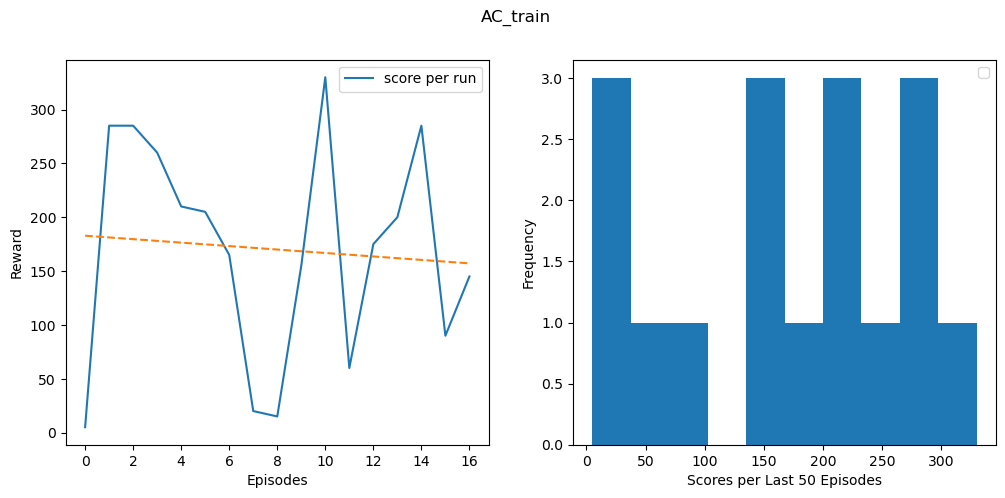

In [71]:
plot_res(score_history,'AC_train')

In [ ]:
score_history = []
n_episodes = 100
for i in range(n_episodes):
        done = False
        score = 0
        observation = env.reset()
        
        while not done:
            
            observation = tf.convert_to_tensor(observation)
            observation = tf.expand_dims(observation, 0)
            
            action_probs, critic_value = model(observation)
            action = np.random.choice(2, p=np.squeeze(action_probs))
            observation, reward, done, info = env.step(action)
            score += reward
        
        score_history.append(score)
        
        avg_score = np.mean(score_history[-100:])
        if i % 10 == 0:
            print('episode ', i,  'avg score %.1f' % avg_score)

In [ ]:
plot_res(Total_reward,'AC_test')

In [78]:
### Load the best model
best_model = sorted(os.listdir("./models/AC_models"))[-1]
print("Loaded: ", best_model)
model = load_model(os.path.join("./models/AC_models",best_model), compile=False)

Loaded:  209.0_5_AC.h5


### 2.2.2 Compare model to random actions

In [79]:
#play 1 game of the best model
epochs, rewards = 0, 0
observation = env.reset()
done = False

while not done:
    state = tf.convert_to_tensor(state)
            
    action_probs, critic_value = model(state)

    p = np.squeeze(action_probs)

    action = np.random.choice(env.action_space.n, p=p[0])
    
    action = np.argmax(predicted)
    observation, reward, done, info = env.step(action)
    env.render()
    rewards  += reward
    epochs += 1
    
env.close()
print(f"Reward: {rewards}") 

ResourceExhaustedError: Exception encountered when calling layer "conv2d_34" "                 f"(type Conv2D).

{{function_node __wrapped__Conv2D_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[4,82,82,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2D]

Call arguments received by layer "conv2d_34" "                 f"(type Conv2D):
  • inputs=tf.Tensor(shape=(4, 84, 84, 1), dtype=float32)

In [10]:
#play 1 game with random actions
epochs, rewards = 0, 0


observation = env.reset()
done = False


while not done:
    
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    env.render()
    rewards  += reward
    epochs += 1
    time.sleep(0.1)
print(f"Reward: { rewards}")
env.close()

Reward: 105.0
